In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import re

In [2]:
class MorseDataset(torch.utils.data.Dataset):
    def __init__(self, audio_dir, csv_path, transform=None, label_transform=None):
        if transform == None:
            transform = lambda x, y: (x, y)
        if label_transform == None:
            label_transform = lambda x: x
        self.audio_dir = audio_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.label_transform = label_transform
        pass

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        record = self.df.iloc[index]
        signal, sr = librosa.load(Path(self.audio_dir, record['id']), sr=None)
        label = record['message']
        return self.transform(signal, sr), self.label_transform(label)


## feature engineering

In [3]:
def negative_entropy(spectrogram: np.ndarray, min_temp=0, max_temp=5, out_channels=64):
    # spectrogram.shape = [C, N]
    temperature = np.linspace(min_temp, max_temp, out_channels)[None, None, :]
    exp = np.exp((spectrogram - np.max(spectrogram, axis=0))[:, :, None] / (np.e ** temperature))
    probs = exp / np.sum(exp, axis=0)
    entropy = np.transpose(-np.sum(probs * np.log(probs + 1e-8), axis=0), axes=(1, 0))
    return -entropy

### text utility

In [4]:
def encode_to_morse(text: str, remove_separator_pad=False):
    encoded = mcp.encode(text, language='russian')
    sharp_code = '--.--'    # #
    hard_code = '.--.-.'
    common_hard_code = '--.--'  # Ъ
    encoded = encoded.replace(common_hard_code, hard_code)
    encoded = encoded.replace('*', sharp_code)

    if remove_separator_pad:
        encoded = encoded.replace('/ ', '/')
        encoded = encoded.replace(' /', '/')
    return encoded

In [5]:
def decode_from_morse(morse: str, separator_pads_removed=False):
    sharp_code = '--.--'    # #
    hard_code = '.--.-.'
    common_hard_code = '--.--'  # Ъ
    # # -> ? -> #
    question_mark_code = '..--..'   # ?
    code = morse.replace(sharp_code, question_mark_code)
    code = code.replace(hard_code, common_hard_code)
    if separator_pads_removed:
        code = code.replace('/', ' / ').strip(' ')
    text = mcp.decode(code, language='russian')
    text = text.replace('?', '#').upper()
    return text

In [6]:
class Vectorizer:
    def __init__(self):
        self.text_to_nums = {
            ' ': 0,
            '.': 1,
            '-': 2,
            '/': 3,
            }
        self.nums_to_text = dict([(v, k) for k, v in self.text_to_nums.items()])
        pass

    def to_tensor(self, text: str):
        return torch.tensor([self.text_to_nums[ch] for ch in text])
    
    def from_tensor(self, tensor: torch.Tensor):
        assert tensor.ndim == 1
        return ''.join([self.nums_to_text[num.item()] for num in tensor])

### engage!

In [7]:
def audio_transform(signal: np.ndarray, sr: int):
    n_fft = 512
    # D = librosa.stft(signal, n_fft=n_fft)
    # spectrogram = np.abs(D)
    # return spectrogram
    melspectrogram = librosa.feature.melspectrogram(y=signal, sr = sr,
												n_mels = 64, n_fft=n_fft, hop_length=n_fft // 4)
    return torch.as_tensor(melspectrogram / np.max(melspectrogram))
    # neg_entropy = negative_entropy(spectrogram, out_channels=64)
    # arr = neg_entropy.transpose((1, 0))
    # # [N, C]
    # return torch.as_tensor(arr)


vec_maker = Vectorizer()


def text_transform(text: str):
    encoded = encode_to_morse(text)
    return vec_maker.to_tensor(encoded) + 1 # for CTC loss


def batch_text_transform(texts: list[str], pad_value = 1):
    vecs = []
    for t in texts:
        vecs.append(text_transform(t))
    lengths = torch.tensor([len(v) for v in vecs])
    desired_length = torch.max(lengths)
    vecs = [F.pad(v, (0, desired_length - len(v)), value=pad_value) for v in vecs]
    batch = torch.stack(vecs, dim=0)
    return batch, lengths

In [8]:
full_train_dataset = MorseDataset('morse_dataset', 'train.csv', transform=audio_transform)

torch.Size([64, 501])
8Й82ЩЬН


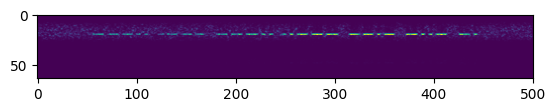

In [9]:
tmp_features, tmp_label = full_train_dataset[6239]
plt.imshow(tmp_features)
print(tmp_features.shape)
print(tmp_label)

In [10]:
full_train_features = [full_train_dataset[i][0] for i in tqdm(range(6000))]
full_train_labels = [full_train_dataset[i][1] for i in tqdm(range(6000))]

100%|██████████| 6000/6000 [00:59<00:00, 100.90it/s]


In [11]:
full_train_labels[:4]

['03ЩУЫЛПИГХ', 'ЪЛТ0ДС6А3Г', '5ЭКЫБЗХЯН', 'ЖЫЦОИ68КФ']

In [12]:
batch_text_transform(full_train_labels[:5])[1].dtype

torch.int64

In [13]:
class ListDataset(torch.utils.data.Dataset):
    def __init__(self, features: list, labels: list):
        self.features = features
        self.labels = labels
        assert len(features) == len(labels)
        pass

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [14]:
from sklearn.model_selection import train_test_split

precomputed_full_train_dataset = ListDataset(full_train_features, full_train_labels)
train_index, test_index = train_test_split(np.arange(len(precomputed_full_train_dataset)), test_size=1/6, shuffle=True, 
                                           random_state=42)
print(train_index.shape, test_index.shape)
trainset = torch.utils.data.Subset(precomputed_full_train_dataset, train_index)
testset = torch.utils.data.Subset(precomputed_full_train_dataset, test_index)

(5000,) (1000,)


In [15]:
torch.max(trainset[200][0])

tensor(1.)

In [16]:
class SimpleConvModel(nn.Module):
    def __init__(self, input_size=64, inner_size=16, output_size=5):
        super().__init__()
        self.estimator = nn.Sequential(
            nn.Conv1d(input_size, inner_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inner_size),
            nn.Conv1d(inner_size, inner_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inner_size),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(inner_size, inner_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(inner_size),
            nn.Conv1d(inner_size, output_size, kernel_size=3),
        )
        pass

    def forward(self, x):
        out = self.estimator(x)
        return out

In [17]:
SimpleConvModel()(trainset[0][0][None]).transpose(0, 2).transpose(1, 2).shape

torch.Size([248, 1, 5])

In [18]:
SimpleConvModel()(trainset[0][0][None]).shape

torch.Size([1, 5, 248])

In [19]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [20]:
model = SimpleConvModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
ctc_loss = nn.CTCLoss()


train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

train_loss_history = []
test_loss_history = []
for epoch in range(15):
    model.train()
    train_loss_buffer = []
    for features, labels in tqdm(train_loader):
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)
        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_buffer.append(loss.detach())
    
    model.eval()
    test_loss_buffer = []
    with torch.no_grad():
        for features, labels in tqdm(test_loader):
            features = features.to(device)
            targets, target_lengths = batch_text_transform(labels)
            targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
            outs = model(features).transpose(0, 2).transpose(1, 2)
            inputs = F.log_softmax(outs, dim=2)
            input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
            loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
            test_loss_buffer.append(loss.detach())
    # print(train_loss_buffer)
    train_loss_value = torch.mean(torch.stack(train_loss_buffer)).item()
    test_loss_value = torch.mean(torch.stack(test_loss_buffer)).item()
    print(f'train loss = {train_loss_value}; test loss = {test_loss_value}')
    train_loss_history.append(train_loss_value)
    test_loss_history.append(test_loss_value)

100%|██████████| 32/32 [00:00<00:00, 58.70it/s]


train loss = 2.583728790283203; test loss = 1.562569260597229


100%|██████████| 32/32 [00:00<00:00, 54.61it/s]


train loss = 1.4709872007369995; test loss = 1.352103590965271


100%|██████████| 32/32 [00:00<00:00, 54.06it/s]


train loss = 1.3230925798416138; test loss = 1.2634018659591675


100%|██████████| 32/32 [00:00<00:00, 58.21it/s]


train loss = 1.2349824905395508; test loss = 1.1696659326553345


100%|██████████| 32/32 [00:00<00:00, 54.32it/s]


train loss = 0.9602881669998169; test loss = 0.7504833340644836


100%|██████████| 32/32 [00:00<00:00, 59.14it/s]


train loss = 0.5882001519203186; test loss = 0.4657215476036072


100%|██████████| 32/32 [00:00<00:00, 53.20it/s]


train loss = 0.39710381627082825; test loss = 0.3678207993507385


100%|██████████| 32/32 [00:00<00:00, 57.46it/s]


train loss = 0.33524051308631897; test loss = 0.3246566355228424


100%|██████████| 32/32 [00:00<00:00, 54.56it/s]


train loss = 0.3048650026321411; test loss = 0.30464860796928406


100%|██████████| 32/32 [00:00<00:00, 59.33it/s]


train loss = 0.288223534822464; test loss = 0.30373167991638184


100%|██████████| 32/32 [00:00<00:00, 56.29it/s]


train loss = 0.2776762843132019; test loss = 0.28079304099082947


100%|██████████| 32/32 [00:00<00:00, 59.25it/s]


train loss = 0.2676286995410919; test loss = 0.2749152183532715


100%|██████████| 32/32 [00:00<00:00, 57.60it/s]


train loss = 0.26162582635879517; test loss = 0.26849016547203064


100%|██████████| 32/32 [00:00<00:00, 56.86it/s]


train loss = 0.2549312114715576; test loss = 0.2621269226074219


100%|██████████| 32/32 [00:00<00:00, 59.34it/s]

train loss = 0.24829764664173126; test loss = 0.255923867225647


Text(0, 0.5, 'value')

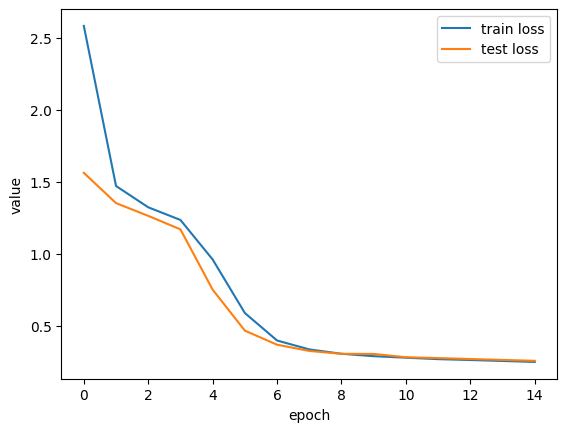

In [21]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('value')

In [22]:
features, labels = testset[996]
print(labels, features.shape)

1 ЫУ9В torch.Size([64, 501])


In [23]:
def map_to_string(tensor: torch.Tensor):
    assert tensor.ndim == 1
    result = []
    the_map = ['$', ' ', '.', '-', '/']
    for i in tensor:
        result.append(the_map[i])
    return ''.join(result)


def prettify_ctc_string(ctc_string):
    text = ctc_string
    text = re.sub('-+', '-', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('/+', '/', text)
    text = re.sub('\.+', '.', text)
    text = re.sub('\$+', '', text)
    text = text.strip()
    return text

In [24]:
def greedy_ctc_sample(probs: torch.Tensor):
    # [C, T]
    assert probs.ndim == 2
    sampled_tensor = torch.argmax(probs, dim=0)
    return sampled_tensor

In [25]:
# stolen from https://sid2697.github.io/Blog_Sid/algorithm/2019/11/04/Beam-search.html

class ShortCTCSampler:
    @staticmethod
    def beam_search_decoder(probability_matrix, beam_width):
        """
        This method is used to get the most probable candidates using beam search decoding algorithm
        probability_matrix: A numpy array of shape (batch_size, number_of_classes)
        beam_width: int denoting beam size
        """
        sequences = [[list(), 1.0]]     # Initializing an empty list for storing sequences and scores
        # iterating through all the steps in the sequence
        for row in probability_matrix:
            all_candidates = list()
            # expand each current candidate
            for i in range(len(sequences)):
                seq, score = sequences[i]   # Getting score and individual sequence
                for j in range(len(row)):
                    # getting score for indiviual class (character)
                    candidate = [seq + [j], (score * row[j])]
                    all_candidates.append(candidate)
            # arrange all candidates by score
            ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
            # select the best candidates
            sequences = ordered[:beam_width]
        return sequences

    @staticmethod
    def sample(probs: torch.Tensor, return_prob = False, beam_size=10):
        # [C, T]
        assert probs.ndim == 2
        beam_out = ShortCTCSampler.beam_search_decoder(probs.transpose(1, 0), beam_size)
        sampled_tensor = torch.tensor(beam_out[0][0])
        if return_prob:
            return sampled_tensor, beam_out[0][1]
        return sampled_tensor
    
    @staticmethod
    def sample_morse(probs: torch.Tensor, beam_size=10):
        return prettify_ctc_string(map_to_string(ShortCTCSampler.sample(probs, beam_size=beam_size)))

In [26]:
"""
Author: Awni Hannun
This is an example CTC decoder written in Python. The code is
intended to be a simple example and is not designed to be
especially efficient.
The algorithm is a prefix beam search for a model trained
with the CTC loss function.
For more details checkout either of these references:
  https://distill.pub/2017/ctc/#inference
  https://arxiv.org/abs/1408.2873
"""

import numpy as np
import math
import collections

NEG_INF = -float("inf")

class LongCTCSampler:
  @staticmethod
  def make_new_beam():
    fn = lambda : (NEG_INF, NEG_INF)
    return collections.defaultdict(fn)

  @staticmethod
  def logsumexp(*args):
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max)
                        for a in args))
    return a_max + lsp

  @staticmethod
  def decode(probs, beam_size=100, blank=0):
    """
    Performs inference for the given output probabilities.
    Arguments:
        probs: The output probabilities (e.g. post-softmax) for each
          time step. Should be an array of shape (time x output dim).
        beam_size (int): Size of the beam to use during inference.
        blank (int): Index of the CTC blank label.
    Returns the output label sequence and the corresponding negative
    log-likelihood estimated by the decoder.
    """
    T, S = probs.shape
    probs = np.log(probs)

    # Elements in the beam are (prefix, (p_blank, p_no_blank))
    # Initialize the beam with the empty sequence, a probability of
    # 1 for ending in blank and zero for ending in non-blank
    # (in log space).
    beam = [(tuple(), (0.0, NEG_INF))]

    for t in range(T): # Loop over time

      # A default dictionary to store the next step candidates.
      next_beam = LongCTCSampler.make_new_beam()

      for s in range(S): # Loop over vocab
        p = probs[t, s]

        # The variables p_b and p_nb are respectively the
        # probabilities for the prefix given that it ends in a
        # blank and does not end in a blank at this time step.
        for prefix, (p_b, p_nb) in beam: # Loop over beam

          # If we propose a blank the prefix doesn't change.
          # Only the probability of ending in blank gets updated.
          if s == blank:
            n_p_b, n_p_nb = next_beam[prefix]
            n_p_b = LongCTCSampler.logsumexp(n_p_b, p_b + p, p_nb + p)
            next_beam[prefix] = (n_p_b, n_p_nb)
            continue

          # Extend the prefix by the new character s and add it to
          # the beam. Only the probability of not ending in blank
          # gets updated.
          end_t = prefix[-1] if prefix else None
          n_prefix = prefix + (s,)
          n_p_b, n_p_nb = next_beam[n_prefix]
          if s != end_t:
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_b + p, p_nb + p)
          else:
            # We don't include the previous probability of not ending
            # in blank (p_nb) if s is repeated at the end. The CTC
            # algorithm merges characters not separated by a blank.
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_b + p)
            
          # *NB* this would be a good place to include an LM score.
          next_beam[n_prefix] = (n_p_b, n_p_nb)

          # If s is repeated at the end we also update the unchanged
          # prefix. This is the merging case.
          if s == end_t:
            n_p_b, n_p_nb = next_beam[prefix]
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_nb + p)
            next_beam[prefix] = (n_p_b, n_p_nb)

      # Sort and trim the beam before moving on to the
      # next time-step.
      beam = sorted(next_beam.items(),
              key=lambda x : LongCTCSampler.logsumexp(*x[1]),
              reverse=True)
      beam = beam[:beam_size]

    best = beam[0]
    return best[0], -LongCTCSampler.logsumexp(*best[1])
  
  @staticmethod
  def sample(probs: torch.Tensor, beam_size=100):
    # probs.shape = [C, T]
    sequence, likelihood = LongCTCSampler.decode(np.asarray(probs.transpose(1, 0)), beam_size=beam_size)
    return sequence, likelihood
  
  @staticmethod
  def sample_in_morse(probs: torch.Tensor, beam_size=100, return_prob=False):
    sequence, likelihood = LongCTCSampler.sample(probs, beam_size=beam_size)
    morse = map_to_string(torch.tensor(sequence))
    morse = morse.strip(' /')
    if return_prob:
      return morse, likelihood
    return morse

In [27]:
model.eval()
with torch.no_grad():
    outs = model(features[None].to(device))
    probs = F.softmax(outs.squeeze(), dim=0)

In [28]:
greedy_alg_string = prettify_ctc_string(map_to_string(greedy_ctc_sample(probs)))
short_alg_string = ShortCTCSampler.sample_morse(probs, beam_size=100)
long_alg_string = LongCTCSampler.sample_in_morse(probs, beam_size=100)

In [29]:
print(f'gtrue  "{encode_to_morse(labels)}"  ->  {labels}')
print()
print(f'greedy "{greedy_alg_string}"    ->  {decode_from_morse(greedy_alg_string)}')
print(f'short  "{short_alg_string}" ->  {decode_from_morse(short_alg_string)}')
print(f'long   "{long_alg_string}"  ->  {decode_from_morse(long_alg_string)}')

gtrue  ".---- / -.-- ..- ----. .--"  ->  1 ЫУ9В

greedy ".---- -.-- ..- ----..--"    ->  1ЫУ*
short  ".---- -.-- ..- ----..--" ->  1ЫУ*
long   ".---- -.-- ..- ----. .--"  ->  1ЫУ9В


In [30]:
def inference_with_different_samplers(index: int):
    features, labels = testset[index]
    model.eval()
    with torch.no_grad():
        outs = model(features[None].to(device))
        probs = F.softmax(outs.squeeze(), dim=0)
    greedy_alg_string = prettify_ctc_string(map_to_string(greedy_ctc_sample(probs)))
    short_alg_string = ShortCTCSampler.sample_morse(probs, beam_size=100)
    long_alg_string = LongCTCSampler.sample_in_morse(probs, beam_size=100)
    print(f'gtrue  "{encode_to_morse(labels)}"  ->  {labels}')
    print()
    print(f'greedy "{greedy_alg_string}"    ->  {decode_from_morse(greedy_alg_string)}')
    print(f'short  "{short_alg_string}" ->  {decode_from_morse(short_alg_string)}')
    print(f'long   "{long_alg_string}"  ->  {decode_from_morse(long_alg_string)}')

In [31]:
inference_with_different_samplers(0)

gtrue  "----- ....- ----. -.-. ...-- - / .... ..---"  ->  049Ц3Т Х2

greedy "----- ....- ----.-.-. ...-- -.... ----"    ->  04*36Ш
short  "----- ....- ----.-.-. ...-- -.... ----" ->  04*36Ш
long   "----- ....- ----.-.-. ...-- - .... ----"  ->  04*3ТХШ


In [32]:
inference_with_different_samplers(1)

gtrue  "....- .-. ---- ..-.. ..--- -. . / --.. -...."  ->  4РШЭ2НЕ З6

greedy "....- .-. ---- ..-.. ..----. .--.. -...."    ->  4РШЭ**6
short  "....- .-. ---- ..-.. ..----. .--.. -...." ->  4РШЭ**6
long   "....- .-. ---- ..-.. ..----. .--.. -...."  ->  4РШЭ**6


In [33]:
inference_with_different_samplers(2)

gtrue  "...- --. -. .--. --.. ..--"  ->  ЖГНПЗЮ

greedy "...---. -. .--. --.. ..--"    ->  *НПЗЮ
short  "...---. -. .--. --.. ..--" ->  *НПЗЮ
long   "...---. -. .--. --.. ..--"  ->  *НПЗЮ


In [34]:
inference_with_different_samplers(123)

gtrue  "..-.. --... ... / .--. -.-- ... ... -- ----."  ->  Э7С ПЫССМ9

greedy "..-.. --... ... .--.-- ... ... -- ----."    ->  Э7С*ССМ9
short  "..-.. --... ... .--.-- ... ... -- ----." ->  Э7С*ССМ9
long   "..-.. --... ... .--.--- ... ... -- ----."  ->  Э7С*ССМ9


In [35]:
inference_with_different_samplers(33)

gtrue  ".-.. ....- - / -. / . . ---. ----- / --.."  ->  Л4Т Н ЕЕЧ0 З

greedy ".-......- --.. . ---. ----- -.-.."    ->  *ЗЕЧ0*
short  ".-......- --.. . ---. ----- -.-.." ->  *ЗЕЧ0*
long   ".--.....- - -.. . ---. ----- --.."  ->  *ТДЕЧ0З


In [36]:
inference_with_different_samplers(882)

gtrue  "- -... .--.-. -... --.-- ..-- -.-"  ->  ТБЪБ#ЮК

greedy "- -... .--.-. -... --.-- ..-- -.-"    ->  ТБЪБ#ЮК
short  "- -... .--.-. -... --.-- ..-- -.-" ->  ТБЪБ#ЮК
long   "- -... .--.-. -... --.-- ..-- -.-"  ->  ТБЪБ#ЮК


In [37]:
inference_with_different_samplers(82)

gtrue  "..--- - --.. -.- .--.-. ---."  ->  2ТЗКЪЧ

greedy "-- ---.. -.- .--.-. ---."    ->  М8КЪЧ
short  "-- ---.. -.- .--.-. ---." ->  М8КЪЧ
long   ".--- ---.. -.- .--.-. ---."  ->  Й8КЪЧ


In [38]:
inference_with_different_samplers(42)

gtrue  "-.-. -.. -..- ..-.. ..-.. --.- .-- ....- ....."  ->  ЦДЬЭЭЩВ45

greedy "-.-. -.. -..- ..-.. ..-.. --.- .-- ....- ....."    ->  ЦДЬЭЭЩВ45
short  "-.-. -.. -..- ..-.. ..-.. --.- .-- ....- ....." ->  ЦДЬЭЭЩВ45
long   "-.-. -.. -..- ..-.. ..-.. --.- .-- ....- ....."  ->  ЦДЬЭЭЩВ45


In [39]:
inference_with_different_samplers(743)

gtrue  "...- ---. ----- -- ..-.. --. --.- ...- .-."  ->  ЖЧ0МЭГЩЖР

greedy "...- ---. ----- -- ..-.. --. --.- ...- .-."    ->  ЖЧ0МЭГЩЖР
short  "...- ---. ----- -- ..-.. --. --.- ...- .-." ->  ЖЧ0МЭГЩЖР
long   "...- ---. ----- -- ..-.. --. --.- ...- .-."  ->  ЖЧ0МЭГЩЖР


In [40]:
inference_with_different_samplers(999)

gtrue  "-.-. --.- --.-- ... .-- -.-. ---."  ->  ЦЩ#СВЦЧ

greedy "-.-. --.- --.-- ... .-- -.-. ---."    ->  ЦЩ#СВЦЧ
short  "-.-. --.- --.-- ... .-- -.-. ---." ->  ЦЩ#СВЦЧ
long   "-.-. --.- --.-- ... .-- -.-. ---."  ->  ЦЩ#СВЦЧ


In [41]:
Levenshtein.distance('hahaha', 'heah')

3

In [42]:
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm(testset):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        morse = LongCTCSampler.sample_in_morse(probs, beam_size=10)
        decoded_message = decode_from_morse(morse)
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)

100%|██████████| 1000/1000 [01:08<00:00, 14.66it/s]


In [43]:
mean_dist

np.float64(2.442)

## make baseline submission

In [44]:
def load_audio_in_memory(audio_dir, filenames, transform=lambda x, y: x):
    records = []
    for name in tqdm(filenames):
        signal, sr = librosa.load(Path(audio_dir, name), sr=None)
        records.append(transform(signal, sr))
    return records

In [45]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id
0,30001.opus
1,30002.opus
2,30003.opus
3,30004.opus
4,30005.opus


In [46]:
test_features = load_audio_in_memory('morse_dataset', test_df['id'], transform=audio_transform)

100%|██████████| 5000/5000 [00:54<00:00, 92.20it/s] 


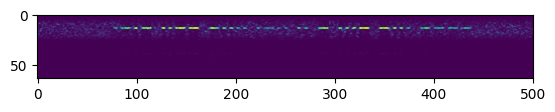

.-.- ..-- -.... .-.. .. - ...- -... ----.


In [47]:
features = test_features[0]
plt.imshow(features)
plt.show()
model.eval()
with torch.no_grad():
    outs = model(features[None].to(device))
    probs = F.softmax(outs.squeeze(), dim=0)
long_alg_string = LongCTCSampler.sample_in_morse(probs, beam_size=100)
print(long_alg_string)

In [48]:
decoded_list = []
model.eval()
for features in tqdm(test_features):
    with torch.no_grad():
        outs = model(features[None].to(device))
        probs = F.softmax(outs.squeeze(), dim=0)
    long_alg_string = LongCTCSampler.sample_in_morse(probs, beam_size=10)
    decoded = decode_from_morse(long_alg_string)
    decoded_list.append(decoded)
    # print(long_alg_string)

 38%|███▊      | 1887/5000 [02:11<03:37, 14.34it/s]


KeyboardInterrupt: 

In [ ]:
submission_df = pd.DataFrame({'id': test_df['id'], 'message': decoded_list})
submission_df.head()

,id,message
0,30001.opus,ЯЮ6ЛИТЖБШ
1,30002.opus,КЩВ9Ю9
2,30003.opus,Ы65Ф61Я
3,30004.opus,ЖЖНЖ9РЫНЦ3
4,30005.opus,ЕЯФ4ЮЧЬ


In [ ]:
submission_df.tail(20)

,id,message
4980,34981.opus,ЛМИТ8ЕНБПУ
4981,34982.opus,ЦОИБСГМ8
4982,34983.opus,5УМ0АО*
4983,34984.opus,ДАМАМТОТ**МК
4984,34985.opus,*СВЕДТ#НТИЯМОМЮНЯММТИЫМ*МЫНШРГЗЕВ
4985,34986.opus,ТНХВЙЕГ*ВЫДАМИНКШ8НИ*НЖТТ
4986,34987.opus,ИЛНАСДПЬСОЕМУНТИЕГВКСОЕПЬКС*СУСХНУЮНХНУХ
4987,34988.opus,ЕТЬТКПДСЯНКМЫОЦИМК
4988,34989.opus,*ЬКМСО*МОПЬ*М
4989,34990.opus,ИЛЬСОЕНДМЫМЙЫНУСЙЫМЧАТУСЬКТДЛХТЫМЖАЛЙДЛУСВМЧТЫ...


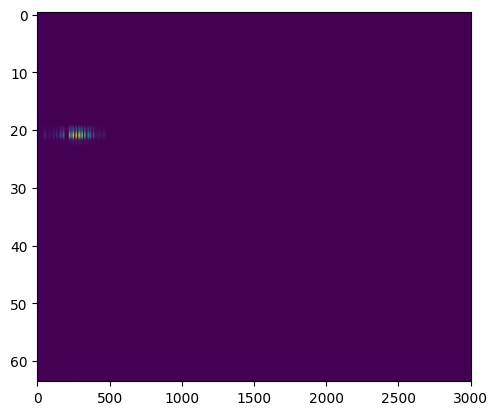

In [49]:
plt.imshow(test_features[4999], aspect=40)

In [ ]:
submission_df.to_csv('baseline_submission.csv', index=False)

8000
-0.9999999982923303 1.7076697119930862e-09


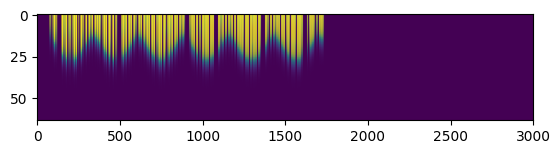

In [50]:
n_fft = 512
filename = '34985.opus'
signal, sr = librosa.load(f'morse_dataset/{filename}', sr=None)
print(sr)
D = librosa.stft(signal, n_fft=n_fft)
spectrogram = np.abs(D)
# plt.imshow(spectrogram, aspect=10)
nent = negative_entropy(spectrogram, max_temp=5)
nent = nent / -(np.min(nent) - np.max(nent))
print(np.min(nent), np.max(nent))
plt.imshow(nent[:, :], aspect=10)

-..-..- ... .-- . -.. ------. .-- -. - ...-.- ------.-- -- ..-- -. .-.- ----.-- - .. -.-- ---..----- ---. -- -.-- -.-.--- -- .-. --. --... .----


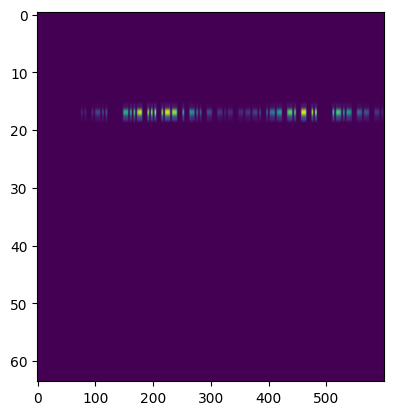

In [51]:
features = audio_transform(signal, sr)
plt.imshow(features[:, :600], aspect=10)
with torch.no_grad():
    outs = model(features[None].to(device))
    probs = F.softmax(outs.squeeze(), dim=0)
    message = LongCTCSampler.sample_in_morse(probs)
print(message)